In [1]:
import allel
import numpy as np

In [4]:
callset = allel.read_vcf('../selection_scan/modern_imputed.vcf.gz')

In [6]:
genotypes = allel.GenotypeArray(callset['calldata/GT'])
haps = genotypes.to_haplotypes()
positions = callset['variants/POS']
chroms = callset['variants/CHROM']

In [107]:
import pandas as pd
import numpy as np
import allel

# Parameters
window_size = 1000  # in bp
step_size = 1000

results = []

for chrom in np.unique(chroms):
    chrom_mask = chroms == chrom
    pos_chrom = positions[chrom_mask]
    haps_chrom = haps[chrom_mask]

    # Use allele counts from haplotypes
    ac = haps_chrom.count_alleles(max_allele=1)  # assuming biallelic

    # Tajima's D
    tajima_d, windows, _ = allel.windowed_tajima_d(
        pos_chrom, ac, size=window_size, step=step_size
    )

    # Segregating sites: count per window
    is_segregating = ac.is_segregating().astype(int)
    seg_sites = []
    for start, end in windows:
        in_window = (pos_chrom >= start) & (pos_chrom < end)
        seg_sites.append(is_segregating[in_window].sum())
    seg_sites = np.array(seg_sites)

    # Store results
    df = pd.DataFrame({
        'chrom': chrom,
        'window_start': windows[:, 0],
        'window_end': windows[:, 1],
        'tajima_d': tajima_d,
        'segregating_sites': seg_sites
    })
    results.append(df)

# Combine all chromosomes
tajima_df = pd.concat(results, ignore_index=True)


In [109]:
tajima_df

,chrom,window_start,window_end,tajima_d,segregating_sites
0,1,332,1331,-0.132333,13
1,1,1332,2331,-0.452213,5
2,1,2332,3331,-0.674828,10
3,1,3332,4331,-1.045914,3
4,1,4332,5331,0.048088,6
...,...,...,...,...,...
118875,5,26786070,26787069,-1.318365,8
118876,5,26787070,26788069,-0.057709,4
118877,5,26788070,26789069,-0.103692,19
118878,5,26789070,26790069,-0.248190,14


In [110]:
# First, sort by chromosome and window_start
tajima_df = tajima_df.sort_values(['chrom', 'window_start'])

# Get chromosome lengths
chrom_max = tajima_df.groupby('chrom')['window_end'].max().sort_index()

# Compute chromosome offsets
chrom_offsets = chrom_max.cumsum() - chrom_max
offset_dict = chrom_offsets.to_dict()

# Apply offset
tajima_df['pos_cum'] = tajima_df.apply(lambda row: row['window_start'] + offset_dict[row['chrom']], axis=1)


In [111]:
tajima_df

,chrom,window_start,window_end,tajima_d,segregating_sites,pos_cum
0,1,332,1331,-0.132333,13,332
1,1,1332,2331,-0.452213,5,1332
2,1,2332,3331,-0.674828,10,2332
3,1,3332,4331,-1.045914,3,3332
4,1,4332,5331,0.048088,6,4332
...,...,...,...,...,...,...
118875,5,26786070,26787069,-1.318365,8,118945884
118876,5,26787070,26788069,-0.057709,4,118946884
118877,5,26788070,26789069,-0.103692,19,118947884
118878,5,26789070,26790069,-0.248190,14,118948884


In [112]:
tajima_df = tajima_df[tajima_df['tajima_d'].notna()]

In [113]:
from scipy.stats import zscore
tajima_df['tajima_d_z'] = zscore(tajima_df['tajima_d'])

/tmp/ipykernel_3885919/1228985322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tajima_df['tajima_d_z'] = zscore(tajima_df['tajima_d'])


In [114]:
tajima_df['chrom'] = tajima_df['chrom'].astype(int)

/tmp/ipykernel_3885919/2253142552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tajima_df['chrom'] = tajima_df['chrom'].astype(int)


In [115]:
tajima_df[tajima_df['tajima_d_z'].isna()]

,chrom,window_start,window_end,tajima_d,segregating_sites,pos_cum,tajima_d_z


In [116]:
gene_df = pd.read_csv('../genes_df.csv')

In [117]:
df = tajima_df.copy()

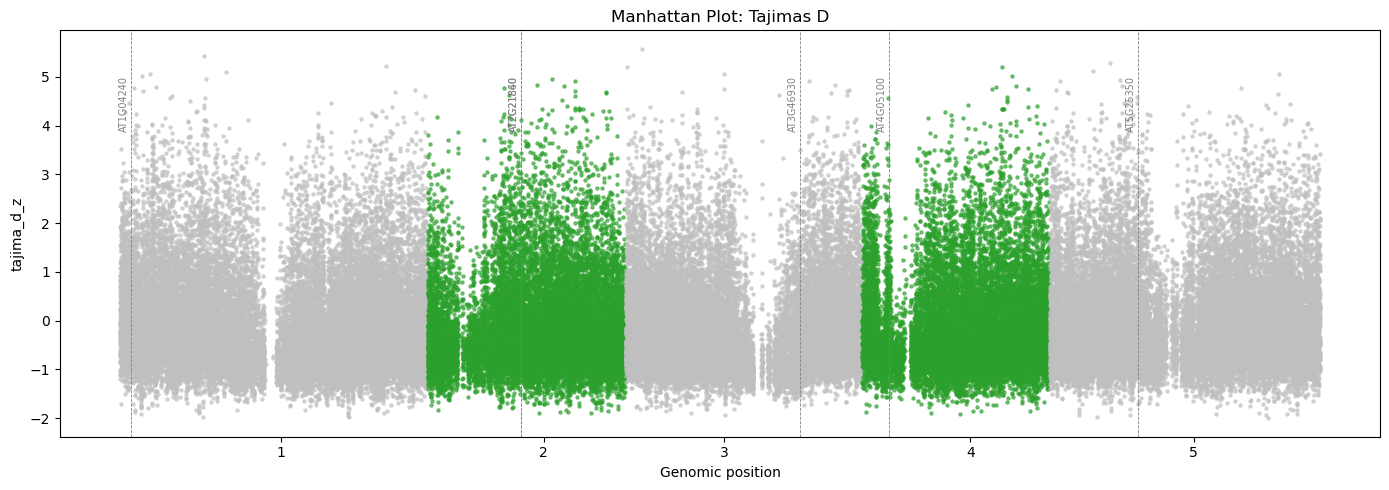

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(tajima_df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['tajima_d_z'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {chrom}')

# Chromosome tick labels
xticks = tajima_df.groupby('chrom')['pos_cum'].median()
xtick_labels = tajima_df.groupby('chrom')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('tajima_d_z')
plt.title('Manhattan Plot: Tajimas D')
plt.legend().remove()

# Annotate gene locations
for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    # Compute gene center
    gene_center = (gene_start + gene_ends) // 2

    # Subset df by chromosome
    subset = df[df['chrom'] == chrom]

    # Find the nearest position to the gene center
    nearest_idx = (subset['window_start'] - gene_center).abs().idxmin()
    gene_pos_cum = subset.loc[nearest_idx, 'pos_cum']

    # Plot vertical line at gene
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['tajima_d_z'].max() * 0.7, gene_id,
             rotation=90, fontsize=7, color='grey', ha='center')

plt.tight_layout()
plt.show()


In [88]:
gene_df = pd.read_csv('../genes_df.csv')

In [90]:
gene_df

,gene_id,chrom,start,end,length
0,AT1G04240,1,1128149,1129689,1540
1,AT2G21840,2,9307024,9310358,3334
2,AT2G21860,2,9318122,9320024,1902
3,AT3G46930,3,17285565,17288077,2512
4,AT4G05100,4,2618372,2619947,1575
5,AT5G25350,5,8794252,8797349,3097


In [ ]:
chrom = 2
gene_start = 9307024
gene_end = 9310358


# Filter region: ±5kb around gene
region_df = tajima_df[(tajima_df['chrom'] == chrom) & (tajima_df['window_start'] >= gene_start - 1000000) & (tajima_df['window_start'] <= gene_end + 1000000)]


region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2



gene_center = (gene_start + gene_end) // 2

# Add distance from gene center
region_df['distance'] = region_df['pos'] - gene_center


/tmp/ipykernel_3885919/2478489237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2
/tmp/ipykernel_3885919/2478489237.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['distance'] = region_df['pos'] - gene_center
/tmp/ipykernel_3885919/2478489237.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

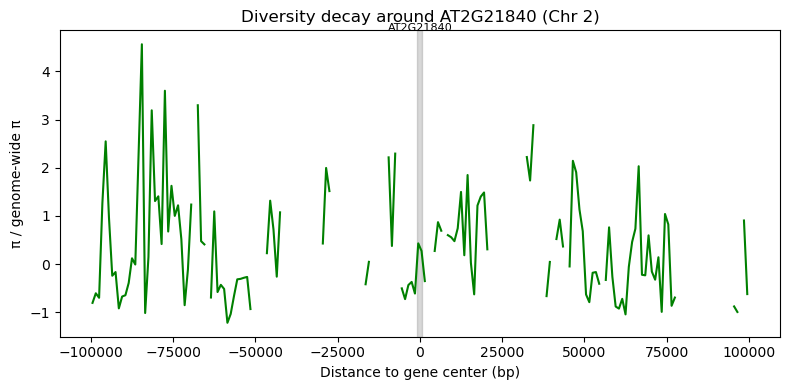

In [95]:
chrom = 4
gene_start = 2618372
gene_end = 2619947


# Filter region: ±5kb around gene
region_df = tajima_df[(tajima_df['chrom'] == chrom) & (tajima_df['window_start'] >= gene_start - 100000) & (tajima_df['window_start'] <= gene_end + 100000)]


region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2



gene_center = (gene_start + gene_end) // 2

# Add distance from gene center
region_df['distance'] = region_df['pos'] - gene_center



# Bin data for SEM calculation
region_df['bin'] = pd.cut(region_df['distance'], bins=np.arange(-100000, 100001, 1000))
binned = region_df.groupby('bin')['tajima_d_z'].agg(['mean', 'sem']).reset_index()
binned['center'] = binned['bin'].apply(lambda x: x.mid)


# Plot
plt.figure(figsize=(8, 4))
plt.plot(binned['center'], binned['mean'], color='green', label='Mean π (normalized)')
plt.fill_between(binned['center'], binned['mean'] - binned['sem'], binned['mean'] + binned['sem'],
                 alpha=0.3, color='green', label='±1 SEM')

# Gene positions
gene1_start, gene1_end = 2618372, 2619947
gene1_center = (gene1_start + gene1_end) // 2

# Add gene spans using same reference point
plt.axvspan(gene1_start - gene1_center, gene1_end - gene1_center, color='grey', alpha=0.3)

# Add labels on top of the shaded boxes
plt.text((gene1_start + gene1_end) / 2 - gene1_center, max(binned['mean']) * 1.05, 'AT2G21840',
         ha='center', va='bottom', fontsize=8, color='black')
# Final plot settings
plt.xlabel('Distance to gene center (bp)')
plt.ylabel('π / genome-wide π')
plt.title('Diversity decay around AT2G21840 (Chr 2)')
plt.tight_layout()
plt.show()


In [119]:
tajima_df

,chrom,window_start,window_end,tajima_d,segregating_sites,pos_cum,tajima_d_z
0,1,332,1331,-0.132333,13,332,0.215861
1,1,1332,2331,-0.452213,5,1332,-0.089913
2,1,2332,3331,-0.674828,10,2332,-0.302711
3,1,3332,4331,-1.045914,3,3332,-0.657432
4,1,4332,5331,0.048088,6,4332,0.388326
...,...,...,...,...,...,...,...
118875,5,26786070,26787069,-1.318365,8,118945884,-0.917868
118876,5,26787070,26788069,-0.057709,4,118946884,0.287194
118877,5,26788070,26789069,-0.103692,19,118947884,0.243239
118878,5,26789070,26790069,-0.248190,14,118948884,0.105113


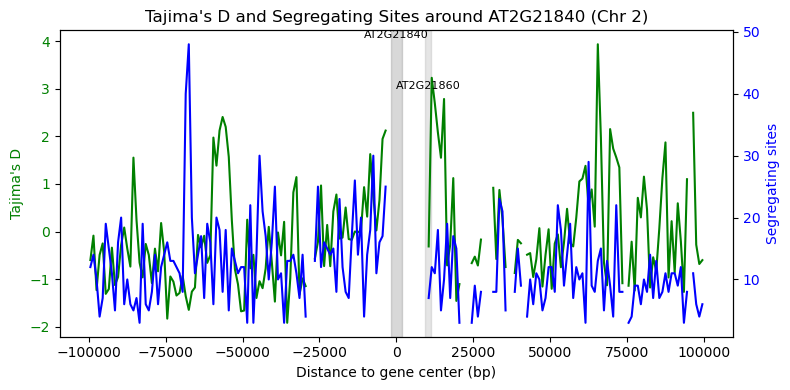

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

chrom = 2
gene_start = 9307024
gene_end = 9310358

# Filter region: ±1Mb around gene
region_df = tajima_df[
    (tajima_df['chrom'] == chrom) &
    (tajima_df['window_start'] >= gene_start - 1_000_000) &
    (tajima_df['window_start'] <= gene_end + 1_000_000)
].copy()

region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2
gene_center = (gene_start + gene_end) // 2
region_df['distance'] = region_df['pos'] - gene_center

# Bin for Tajima's D
region_df['bin'] = pd.cut(region_df['distance'], bins=np.arange(-100000, 100001, 1000))
binned = region_df.groupby('bin').agg({
    'tajima_d': ['mean', 'sem'],
    'segregating_sites': 'mean'
}).reset_index()

binned.columns = ['bin', 'tajima_d_mean', 'tajima_d_sem', 'seg_sites_mean']
binned['center'] = binned['bin'].apply(lambda x: x.mid)

# Create the plot with dual y-axis
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Tajima's D
ax1.plot(binned['center'], binned['tajima_d_mean'], color='green', label='Mean Tajima\'s D')
ax1.fill_between(
    binned['center'],
    binned['tajima_d_mean'] - binned['tajima_d_sem'],
    binned['tajima_d_mean'] + binned['tajima_d_sem'],
    alpha=0.3, color='green', label='±1 SEM'
)
ax1.set_xlabel('Distance to gene center (bp)')
ax1.set_ylabel('Tajima\'s D', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Plot segregating sites on second axis
ax2 = ax1.twinx()
ax2.plot(binned['center'], binned['seg_sites_mean'], color='blue', label='Mean segregating sites')
ax2.set_ylabel('Segregating sites', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Annotate genes
gene1_start, gene1_end = 9307024, 9310358
gene2_start, gene2_end = 9318122, 9320024
gene1_center = (gene1_start + gene1_end) // 2

ax1.axvspan(gene1_start - gene1_center, gene1_end - gene1_center, color='grey', alpha=0.3)
ax1.axvspan(gene2_start - gene1_center, gene2_end - gene1_center, color='darkgrey', alpha=0.3)

ax1.text((gene1_start + gene1_end) / 2 - gene1_center, ax1.get_ylim()[1] * 0.95, 'AT2G21840',
         ha='center', va='bottom', fontsize=8, color='black')
ax1.text((gene2_start + gene2_end) / 2 - gene1_center, ax1.get_ylim()[1] * 0.7, 'AT2G21860',
         ha='center', va='bottom', fontsize=8, color='black')

plt.title('Tajima\'s D and Segregating Sites around AT2G21840 (Chr 2)')
fig.tight_layout()
plt.show()


In [125]:
gene_df

,gene_id,chrom,start,end,length
0,AT1G04240,1,1128149,1129689,1540
1,AT2G21840,2,9307024,9310358,3334
2,AT2G21860,2,9318122,9320024,1902
3,AT3G46930,3,17285565,17288077,2512
4,AT4G05100,4,2618372,2619947,1575
5,AT5G25350,5,8794252,8797349,3097


In [129]:
chrom = 2
gene_start = 9307024
gene_end = 9310358
gene_id = 'AT2G21840'

# Filter region: ±5kb around gene
region_df = df[(df['chrom'] == chrom) & (df['window_start'] >= gene_start - 10000) & (df['window_start'] <= gene_end + 10000)]


In [130]:
region_df

,chrom,window_start,window_end,tajima_d,segregating_sites,pos_cum,tajima_d_z
39645,2,9297847,9298846,0.932428,4,39716095,1.233668
39646,2,9298847,9299846,0.313355,14,39717095,0.641895
39647,2,9299847,9300846,1.627118,18,39718095,1.897723
39648,2,9300847,9301846,0.740541,30,39719095,1.050242
39649,2,9301847,9302846,0.023262,11,39720095,0.364595
39650,2,9302847,9303846,0.660866,16,39721095,0.974081
39651,2,9303847,9304846,1.945752,17,39722095,2.202305
39652,2,9304847,9305846,2.121518,25,39723095,2.370320
39666,2,9318847,9319846,-0.313460,7,39737095,0.042721
39667,2,9319847,9320846,3.230610,12,39738095,3.430502


In [124]:
tajima_df['']

,chrom,window_start,window_end,tajima_d,segregating_sites,pos_cum,tajima_d_z
0,1,332,1331,-0.132333,13,332,0.215861
1,1,1332,2331,-0.452213,5,1332,-0.089913
2,1,2332,3331,-0.674828,10,2332,-0.302711
3,1,3332,4331,-1.045914,3,3332,-0.657432
4,1,4332,5331,0.048088,6,4332,0.388326
...,...,...,...,...,...,...,...
118875,5,26786070,26787069,-1.318365,8,118945884,-0.917868
118876,5,26787070,26788069,-0.057709,4,118946884,0.287194
118877,5,26788070,26789069,-0.103692,19,118947884,0.243239
118878,5,26789070,26790069,-0.248190,14,118948884,0.105113


In [67]:
tajima_df.to_csv('tajima_df.csv',index=None)

In [68]:
chrom = 2
gene_start = 9307024
gene_end = 9310358


# Filter region: ±5kb around gene
region_df = pi_df[(pi_df['chrom'] == chrom) & (pi_df['window_start'] >= gene_start - 30000) & (pi_df['window_start'] <= gene_end + 30000)]


region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2



gene_center = (gene_start + gene_end) // 2

# Add distance from gene center
region_df['distance'] = region_df['pos'] - gene_center

# Bin data for SEM calculation
region_df['bin'] = pd.cut(region_df['distance'], bins=np.arange(-100000, 100001, 500))
binned = region_df.groupby('bin')['pi_z'].agg(['mean', 'sem']).reset_index()
binned['center'] = binned['bin'].apply(lambda x: x.mid)


# Plot
plt.figure(figsize=(8, 4))
plt.plot(binned['center'], binned['mean'], color='green', label='Mean π (normalized)')
plt.fill_between(binned['center'], binned['mean'] - binned['sem'], binned['mean'] + binned['sem'],
                 alpha=0.3, color='green', label='±1 SEM')

# Gene positions
gene1_start, gene1_end = 9307024, 9310358
gene2_start, gene2_end = 9318122, 9320024
gene1_center = (gene1_start + gene1_end) // 2

# Add gene spans using same reference point
plt.axvspan(gene1_start - gene1_center, gene1_end - gene1_center, color='grey', alpha=0.3)
plt.axvspan(gene2_start - gene1_center, gene2_end - gene1_center, color='darkgrey', alpha=0.3)

# Add labels on top of the shaded boxes
plt.text((gene1_start + gene1_end) / 2 - gene1_center, max(binned['mean']) * 1.05, 'AT2G21840',
         ha='center', va='bottom', fontsize=8, color='black')
plt.text((gene2_start + gene2_end) / 2 - gene1_center, max(binned['mean']) * 0.7, 'AT2G21860',
         ha='center', va='bottom', fontsize=8, color='black')

# Final plot settings
plt.xlabel('Distance to gene center (bp)')
plt.ylabel('π / genome-wide π')
plt.title('Diversity decay around AT2G21840 (Chr 2)')
plt.tight_layout()
plt.show()


NameError: name 'pi_df' is not defined

In [69]:
df = tajima_df.copy()

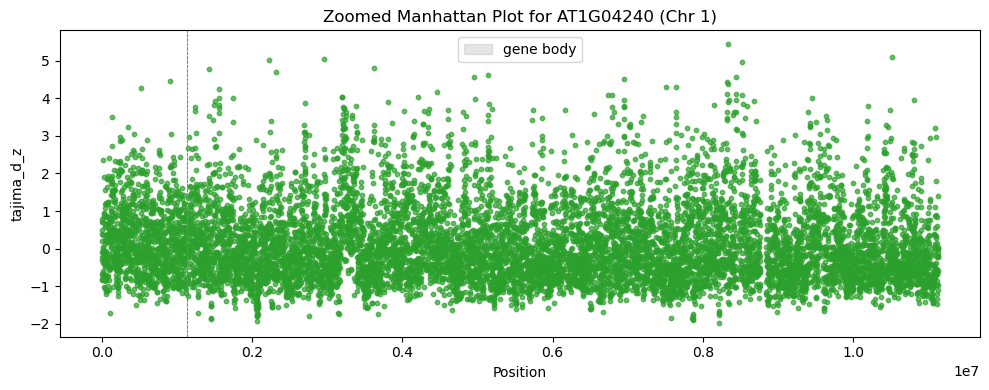

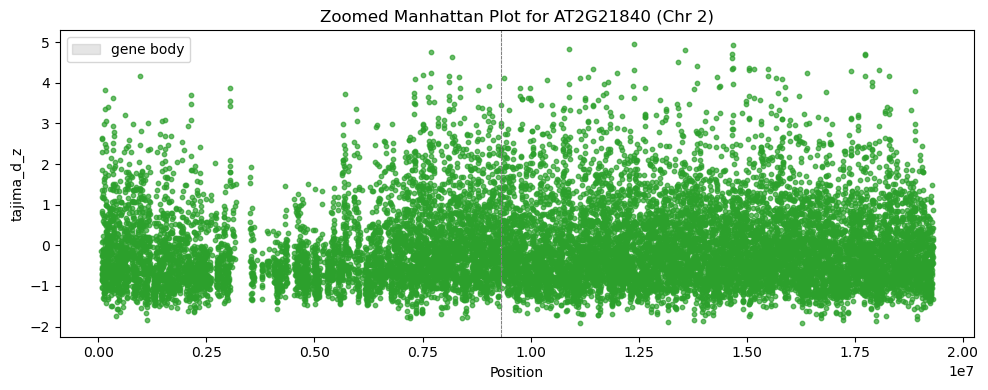

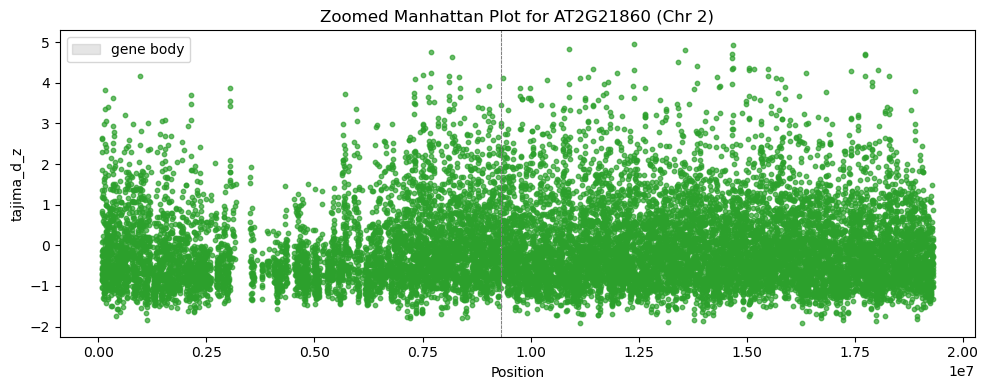

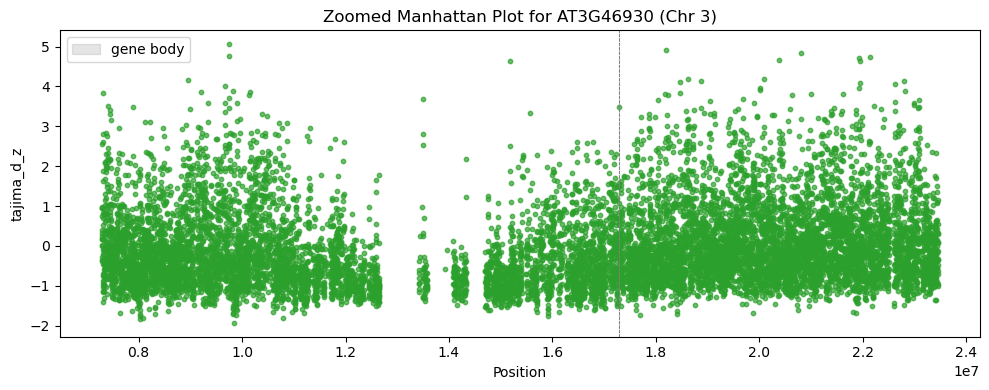

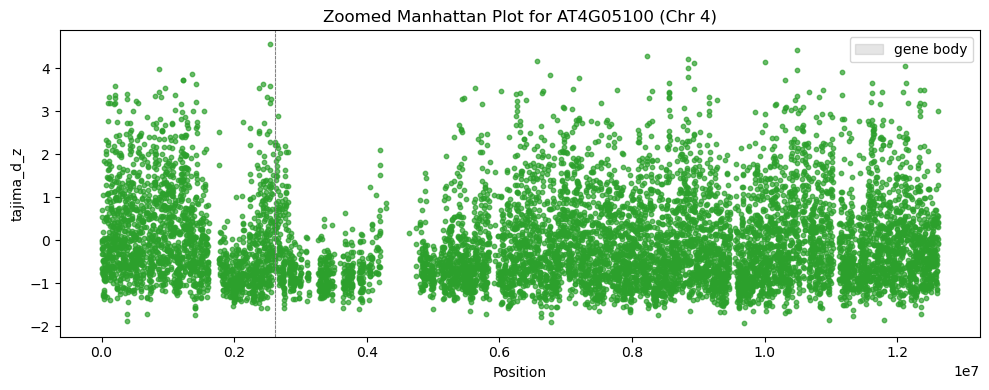

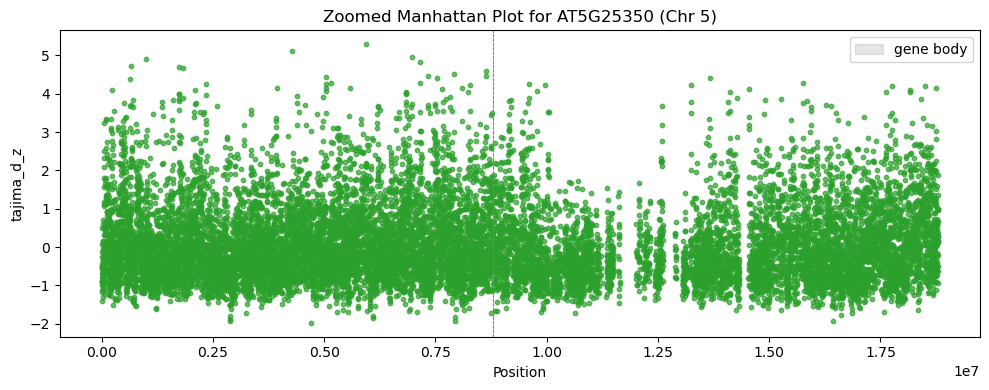

In [97]:
import matplotlib.pyplot as plt

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']
    
    # Filter region: ±5kb around gene
    region_df = df[(df['chrom'] == chrom) & (df['window_start'] >= gene_start - 10000000) & (df['window_start'] <= gene_end + 10000000)]

    if region_df.empty:
        continue  # Skip if no data in region

    plt.figure(figsize=(10, 4))

    # Manhattan-style scatter
    plt.scatter(region_df['window_start'], region_df['tajima_d_z'], s=10, alpha=0.7, color='#2ca02c')
    
    # Gene region highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Plot labels
    plt.title(f'Zoomed Manhattan Plot for {gene_id} (Chr {chrom})')
    plt.xlabel('Position')
    plt.ylabel('tajima_d_z')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [26]:
region_df

,chrom,window_start,window_end,tajima_d,pos_cum,tajima_d_z


In [47]:
df = pi_df.copy()

In [48]:
df.dtypes

window_start      int64
window_end        int64
pi              float64
chrom             int64
pos_cum         float64
dtype: object

In [49]:
pi_df

,window_start,window_end,pi,chrom,pos_cum
885325,1,100,0.000000,1,1.0
885326,101,200,0.000000,1,101.0
885327,201,300,0.000000,1,201.0
885328,301,400,0.594052,1,301.0
885329,401,500,0.181326,1,401.0
...,...,...,...,...,...
267903,26790301,26790400,0.072643,5,118950301.0
267904,26790401,26790500,0.932340,5,118950401.0
267905,26790501,26790600,0.000000,5,118950501.0
267906,26790601,26790700,0.000000,5,118950601.0
